In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#------------------------------------------------------
def notch_reject_filter(shape, d0=9, x=0, y=0):
    """
    建立 Notch Reject 濾波器。
    濾波器會針對頻譜中的某一區域及其對稱點進行屏蔽。

    Parameters:
    - shape: 影像的大小 (rows, cols)
    - d0: 半徑大小，控制濾波範圍
    - x, y: 濾波器中心點，使用左上角 (0, 0) 為基準的座標

    Returns:
    - H: Notch 濾波器 (2D numpy array)
    """
    P, Q = shape
    H = np.ones((P, Q))  # 初始化為全通濾波器 (值為1)

    # 將座標轉換到頻譜中心
    x_c = x - Q / 2
    y_c = y - P / 2

    # 針對頻譜每個點計算距離，決定是否濾波
    for v in range(P):
        for u in range(Q):
            # 計算距離 (針對目標頻率點和對稱頻率點)
            u_c = u - Q / 2 
            v_c = v - P / 2
            D_uv = np.sqrt((u_c + x_c) ** 2 + (v_c + y_c) ** 2)
            D_muv = np.sqrt((u_c - x_c) ** 2 + (v_c - y_c) ** 2)

            # 如果在半徑範圍內，設為0 (濾波區域)
            if D_uv <= d0 or D_muv <= d0:
                H[v, u] = 0.0

    return H

def apply_filter(file_name, notch_param):

    # 1. 讀取影像
    img = cv2.imread(file_name, 0)  # 讀取灰階影像

    # 2. 進行傅立葉轉換，轉換到頻域
    f = np.fft.fft2(img)  # 計算傅立葉變換
    fshift = np.fft.fftshift(f)  # 將低頻移到中心位置
    magnitude_spectrum = 20 * np.log(np.abs(fshift))  # 計算頻譜 (取對數以增強可視化效果)

    # 3. 獲取影像尺寸
    img_shape = img.shape

    print(notch_param)

    for index, (d0, x, y) in enumerate(notch_param):
        print(f"Notch Filters ({index}): d0 = {d0}, x = {x}, y = {y}")
        mask = notch_reject_filter(img_shape, d0=d0, x=x, y=y)
        NotchFilter = NotchFilter * mask if index else mask

    NotchRejectCenter = fshift * NotchFilter  # 在頻域乘上濾波器
    NotchReject = np.fft.ifftshift(NotchRejectCenter)  # 反向位移，將頻譜移回原位置
    inverse_NotchReject = np.fft.ifft2(NotchReject)  # 進行逆傅立葉變換
    Result = np.abs(inverse_NotchReject)  # 計算結果影像的幅值

    plt.figure(figsize=(9,9))
    plt.subplot(2, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # 頻譜圖
    plt.subplot(2, 2, 2)
    plt.imshow(magnitude_spectrum, cmap='gray')
    cv2.imwrite("car_magnitude.jpg", magnitude_spectrum)  # 儲存頻譜影像
    plt.title('Magnitude Spectrum')


    plt.subplot(2, 2, 3)
    plt.imshow(Result, cmap="gray")
    plt.title("Filtered Image (Result)")

    # 濾波器作用後的頻譜
    plt.subplot(2, 2, 4)
    plt.imshow(magnitude_spectrum * NotchFilter, cmap="gray")
    plt.title("Notch Reject Filter")

    plt.tight_layout()
    plt.show()


[(10, 112, 167), (10, 112, 125), (10, 168, 163), (10, 168, 123)]
Notch Filters (0): d0 = 10, x = 112, y = 167
Notch Filters (1): d0 = 10, x = 112, y = 125
Notch Filters (2): d0 = 10, x = 168, y = 163
Notch Filters (3): d0 = 10, x = 168, y = 123


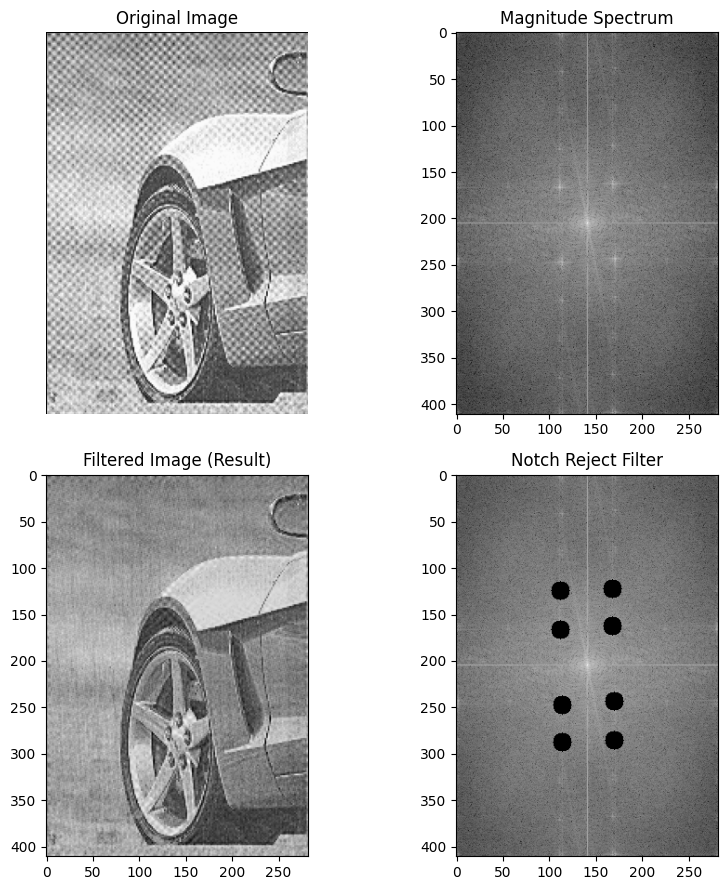

In [35]:
notch_param = [
    (10,112,167),
    (10,112,125),
    (10,168,163),
    (10,168,123),
]

apply_filter("../imgs/car.png", notch_param)



[(10, 400, 300)]
Notch Filters (0): d0 = 10, x = 400, y = 300


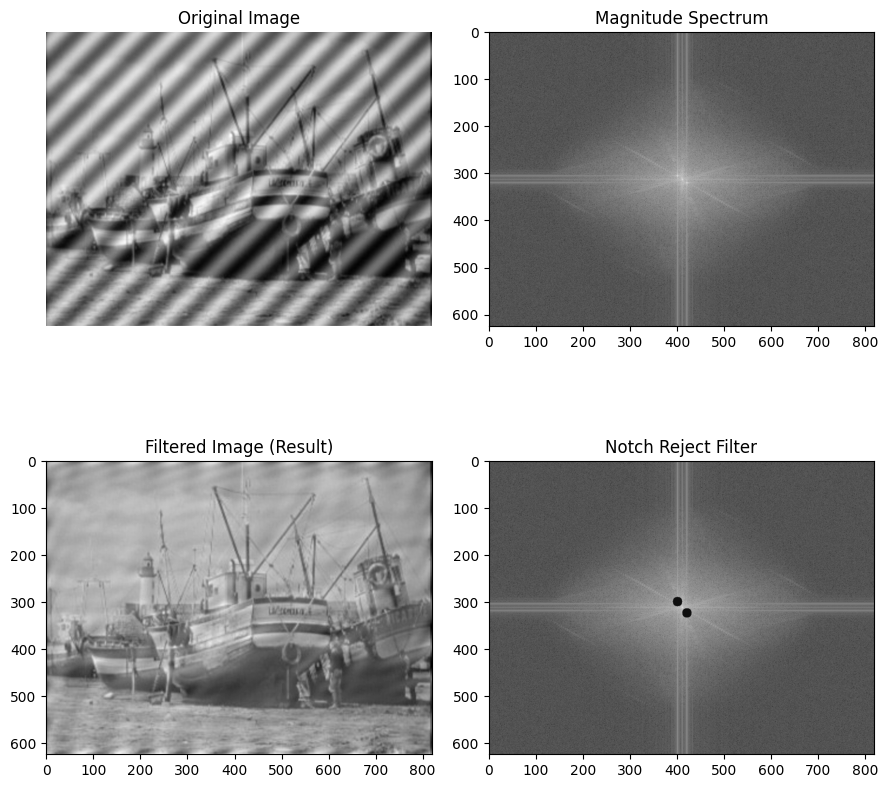

In [41]:
notch_param = [
    (10,400,300),
]

apply_filter("../imgs/ship.png", notch_param)